# Maldives 2040

Abbreviations:
air-conditioning  (AC) \
Seawater air conditioning (SWAC) \
Reverse Osmosis desalination (RO) \
Deep Seawater Cooling and Desalination (DSCD) 

## 2 METHODOLOGY                                       

In [1]:
import itertools
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import ixmp
import message_ix

from message_ix.utils import make_df

<IPython.core.display.Javascript object>

In [2]:
mp = ixmp.Platform()

In [3]:
#scen = "baseline"
#version = 1
scenario = message_ix.Scenario(mp, model="Maldives energy model",
                               scenario='baseline', version='new')

### Time and Spatial Detail

Horizons: 2025, 2030, 2035, 2040.


In [4]:
history = [2015]
horizon = [2020, 2025, 2030, 2035, 2040]
scenario.add_horizon(year= history + horizon, firstmodelyear=horizon[0])

In [5]:
country = 'Maldives'
scenario.add_spatial_sets({'country': country})

In [6]:
scenario.add_set("commodity", ["electricity", 'freshwater', 'cooling', 'other_electricity'])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['oil_ppl', 'solar_pv_ppl', 'battery_ppl', 'ro_pl', 'appliances'])
scenario.add_set("mode", "standard")

### 2.1 Growth estimation

<AxesSubplot:title={'center':'Demand'}>

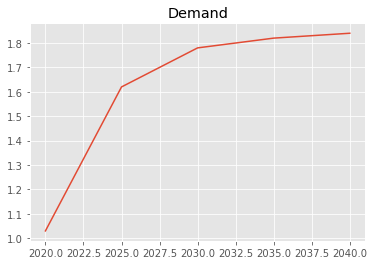

In [7]:
#growth for years 2020, 2025, 2030, 2035, 2040
demand = pd.Series([1.03, 1.62, 1.78, 1.82, 1.84], index=horizon) # data from electricity growth from 2017 up to 2037
demand.plot(title='Demand')

In [8]:
e_plants = [
    "battery_ppl",  #electricity plants
    "oil_ppl", 
    "solar_pv_ppl",
]
w_plants = [ 
    "ro_pl",  #desalination plant
]

secondary_energy_techs = e_plants + w_plants 

others = ['appliances'] #others electricity demand

useful_techs = ['ac', 'swac', 'dscd'] #+ others

In [9]:
technologies = secondary_energy_techs + useful_techs
scenario.add_set("technology", technologies)

### 2.2 Demand for electricity, cooling and freshwater

In [10]:
# Adding a new unit to the library
mp.add_unit('MWta')
mp.add_unit('MWa')
mp.add_unit('m^3a')

ac_demand_per_year = (91800*3) #air conditiong energy demand in 2017
ac_demand = pd.DataFrame({
        'node': country,
        'commodity': 'cooling',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': ac_demand_per_year*demand,
        'unit': 'MWta',
    })
scenario.add_par("demand", ac_demand)

others_demand_per_year = 214200
others_demand = pd.DataFrame({
        'node': country,
        'commodity': 'other_electricity',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': others_demand_per_year * demand,
        'unit': 'MWa',
    })
scenario.add_par("demand", others_demand)

freshwater_demand_per_year = 80000*365 #80,000 m^3/d
freshwater_demand = pd.DataFrame({
        'node': country,
        'commodity': 'freshwater',
        'level': 'useful',
        'year': horizon,
        'time': 'year',
        'value': freshwater_demand_per_year * demand,
        'unit': 'm^3a', 
    })
scenario.add_par("demand", freshwater_demand)   

INFO:root:unit `MWta` is already defined in the platform instance
INFO:root:unit `MWa` is already defined in the platform instance
INFO:root:unit `m^3a` is already defined in the platform instance


In [11]:
ac_demand

,node,commodity,level,year,time,value,unit
2020,Maldives,cooling,useful,2020,year,283662.0,MWta
2025,Maldives,cooling,useful,2025,year,446148.0,MWta
2030,Maldives,cooling,useful,2030,year,490212.0,MWta
2035,Maldives,cooling,useful,2035,year,501228.0,MWta
2040,Maldives,cooling,useful,2040,year,506736.0,MWta


In [12]:
others_demand

,node,commodity,level,year,time,value,unit
2020,Maldives,other_electricity,useful,2020,year,220626.0,MWa
2025,Maldives,other_electricity,useful,2025,year,347004.0,MWa
2030,Maldives,other_electricity,useful,2030,year,381276.0,MWa
2035,Maldives,other_electricity,useful,2035,year,389844.0,MWa
2040,Maldives,other_electricity,useful,2040,year,394128.0,MWa


### 2.3 Engineering Parameters: inputs and outputs

In [13]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act'] 

In [14]:
base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [15]:
#others_electricity

app_in = make_df(base_input, technology='appliances', commodity='electricity',  
                  level='final', value=1., unit="MWa")
scenario.add_par('input', app_in)
app_out = make_df(base_output, technology='appliances', commodity='other_electricity', 
              level='useful', value=1., unit="MWa")
scenario.add_par('output', app_out)

In [16]:
#air conditioning
ac_in = make_df(base_input, technology='ac', commodity='electricity',  
                  level='final', value=1., unit="MWa")
scenario.add_par('input', ac_in)
ac_out = make_df(base_output, technology='ac', commodity='cooling', 
                   level='useful', value=3., unit='MWta')
scenario.add_par('output', ac_out)

In [17]:
#Seawater air conditioning (swac)
swac_in = make_df(base_input, technology='swac', commodity='electricity',  
                  level='final', value=1., unit="MWa")
scenario.add_par('input', swac_in)
swac_out = make_df(base_output, technology='swac', commodity='cooling', 
                   level='useful', value=20, unit='MWta')
scenario.add_par('output', swac_out)

In [18]:
#secondary to useful w_tec

#reverse osmosis - water demand (row)
ro_in = make_df(base_input, technology='ro_pl', commodity='electricity',  
                  level='final', value=1., unit="MWa")
scenario.add_par('input', ro_in)
ro_out = make_df(base_output, technology='ro_pl', commodity='freshwater', 
                   level='useful', value=0.1, unit="m^3a")
scenario.add_par('output', ro_out)

In [19]:
#dscd
#deep seawater cooling and desalination - cooling demand (dscdc)

dscdc_in = make_df(base_input, technology='dscd', commodity='electricity',  
                  level='final', value=1., unit="MWa")
scenario.add_par('input', dscdc_in)
dscdc_out = make_df(base_output, technology='dscd', commodity='cooling', 
                   level='useful', value=20, unit="MWta")
scenario.add_par('output', dscdc_out)
dscdw_out = make_df(base_output, technology='dscd', commodity='freshwater', 
                   level='useful', value=0.1, unit="m^3a")
scenario.add_par('output', dscdw_out)

In [20]:
#secondary to useful e_tecs

oil_out = make_df(base_output, technology='oil_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa")
scenario.add_par('output', oil_out)

solar_pv_out = make_df(base_output, technology='solar_pv_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa")
scenario.add_par('output', solar_pv_out)

battery_out = make_df(base_output, technology='battery_ppl', commodity='electricity', 
                   level='final', value=1., unit="MWa")
scenario.add_par('output', battery_out)

### 2.4 Operational Constraints and Parameters

In [21]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

capacity_factor = {
    'oil_ppl': 0.75,
    'battery_ppl': 0.3, 
    'solar_pv_ppl': 0.3,
    'ac': 0.3,
    'ro_pl': 0.8,
    'swac': 0.8, 
    'dscd': 0.8, 
    'appliances': 0.5
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

In [22]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': horizon,
    'unit': 'y',
}

lifetimes = {
    'oil_ppl': 30,
    'battery_ppl': 5,
    'solar_pv_ppl': 20,
    'ac': 15,
    'ro_pl': 20,
    'swac': 20, 
    'dscd': 20, 
    'appliances': 10
}

for tec, val in lifetimes.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

### 2.5 Technological Diffusion and Contraction

In [23]:
base_growth = {
    'node_loc': country,
    'year_vtg': horizon,
    'time': 'year',
    'unit': '-',
}

In [24]:
growth_technologies = {
    "solar_pv_ppl": 1.9, 
    "swac": 2,
    "dscd": 2,
    'ac': 0.25
}

for tec, val in growth_technologies.items():
    df = make_df(base_growth, technology=tec, value=val) 
    scenario.add_par('growth_new_capacity_up', df)

In [25]:
hist_e_gen = others_demand_per_year + ac_demand_per_year/3
hist_c_gen = ac_demand_per_year/3
hist_w_gen = freshwater_demand_per_year

In [26]:
hist_e_gen

306000.0

In [27]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': '-',
}

base_activity = {
    'node_loc': country,
    'year_vtg': history,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

In [28]:
old_activity = {
    'solar_pv_ppl': .05*hist_e_gen,
    'oil_ppl': .95*hist_e_gen,
    'ac':  .9 * hist_c_gen,
    'swac': .05 * hist_c_gen,
    'dscd': .05* hist_c_gen,
    'ro_pl': 0.95*hist_w_gen,
        
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('initial_new_capacity_up', df)

In [29]:
act_to_cap = {
    'solar_pv_ppl': 1 / 10 / capacity_factor['solar_pv_ppl'] / 2, # 20 year lifetime
    'swac': 1 / 10 / capacity_factor['swac'] / 2,
    'dscd': 1 / 10 / capacity_factor['dscd'] / 2,
    'ac': 1 / 10 / capacity_factor['ac'] / 1.5,
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

In [30]:
scenario.add_par("interestrate", horizon, value=0.05, unit='-')

### 2.6Technoeconomic Parameters

In [31]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': horizon, 
    'unit': 'USD/kW',
}

costs = {
    'oil_ppl': 950, #value from Austria baseline model 
    'battery_ppl': 450, #value from MESSAGE-BRAZIL baseline 
    'solar_pv_ppl': 677, #value from IEA for India in 2019
    'ac': 450, #average price for commercial buildings in USA
    'ro_pl': 950, # in this case it is USD/km³ 
    'swac': 768, # USD/kW
    'dscd': (950 + 768)*0.7, 
    'appliances': 50
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

In [32]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}


costs = {
    'oil_ppl': 25, #value from Austria baseline model 
    'battery_ppl': 32, #value from MESSAGE-BRAZIL baseline
    'solar_pv_ppl': 5, #value from MESSAGE-BRAZIL baseline
    'ac': 30, 
    'ro_pl': 280,
    'swac': 195., 
    'dscd': (280+195)*0.7, 
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

In [33]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

costs = {
    'oil_ppl': 77.8, #value from Austria baseline model 
    'battery_ppl': 0, #value from MESSAGE-BRAZIL baseline
    'solar_pv_ppl': 0, #value from MESSAGE-BRAZIL baseline
    'ro_pl': 0,
    'swac': 0., 
    'dscd': 0, 
    #'appliances': 0.
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val) 
    scenario.add_par('var_cost', df)

### Emissions

In [34]:
scenario.add_set('emission', 'CO2')
scenario.add_cat('emission', 'GHG', 'CO2')

# we now add CO2 emissions to the coal powerplant
base_emission_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'unit': 'tCO2/MWh',
}

# adding new units to the model library (needed only once)
mp.add_unit('tCO2/MWh')
mp.add_unit('MtCO2')

emission_factor = make_df(base_emission_factor, technology= 'oil_ppl', emission= 'CO2', value = 0.57)
scenario.add_par('emission_factor', emission_factor)

INFO:root:unit `tCO2/MWh` is already defined in the platform instance
INFO:root:unit `MtCO2` is already defined in the platform instance


### Commit the datastructure and solve the model

In [35]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))
scenario.commit(comment='basic model of Maldives')
log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 95


In [36]:
scenario.set_as_default()

In [37]:
scenario.solve()

In [38]:
scenario.var('OBJ')['lvl']

3836130361344.0

## 3. Plotting Results

In [39]:
import pyam
from ixmp.reporting import configure
from message_ix.reporting import Reporter
import os
import matplotlib.pyplot as plt
configure(units={'replace': {'-': 'MWa'}})

In [40]:
rep = Reporter.from_scenario(scenario)

In [41]:
# plotting years
plotyrs = [x for x in set(scenario.set('year')) if x >= scenario.firstmodelyear]

In [42]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

nl        t     ya    c        l     
Maldives  ac    2020  cooling  useful         0.0
                2025  cooling  useful         0.0
                2030  cooling  useful         0.0
                2035  cooling  useful         0.0
                2040  cooling  useful         0.0
          dscd  2020  cooling  useful    283662.0
                2025  cooling  useful    446148.0
                2030  cooling  useful    490212.0
                2035  cooling  useful    501228.0
                2040  cooling  useful    506736.0
          swac  2020  cooling  useful         0.0
                2025  cooling  useful         0.0
                2030  cooling  useful         0.0
                2035  cooling  useful         0.0
                2040  cooling  useful         0.0
dtype: float64

In [43]:
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

nl        t             ya    c            l    
Maldives  battery_ppl   2020  electricity  final    0.000000e+00
                        2025  electricity  final    0.000000e+00
                        2030  electricity  final    0.000000e+00
                        2035  electricity  final    0.000000e+00
                        2040  electricity  final    0.000000e+00
          oil_ppl       2020  electricity  final    3.001508e+08
                        2025  electricity  final    3.001508e+08
                        2030  electricity  final    3.001508e+08
                        2035  electricity  final    3.001508e+08
                        2040  electricity  final    3.001508e+08
          solar_pv_ppl  2020  electricity  final    8.298050e+05
                        2025  electricity  final    1.732362e+08
                        2030  electricity  final    2.199905e+08
                        2035  electricity  final    2.316790e+08
                        2040  electricity

In [44]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = elec.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

nl        t      ya    c           l     
Maldives  dscd   2020  freshwater  useful        1418.31
                 2025  freshwater  useful        2230.74
                 2030  freshwater  useful        2451.06
                 2035  freshwater  useful        2506.14
                 2040  freshwater  useful        2533.68
          ro_pl  2020  freshwater  useful    30074581.69
                 2025  freshwater  useful    47301769.26
                 2030  freshwater  useful    51973548.94
                 2035  freshwater  useful    53141493.86
                 2040  freshwater  useful    53725466.32
dtype: float64

In [45]:
rep.set_filters(c = 'other_electricity')
wat = rep.full_key('out')
wat = elec.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

nl        t           ya    c                  l     
Maldives  appliances  2020  other_electricity  useful    220626.0
                      2025  other_electricity  useful    347004.0
                      2030  other_electricity  useful    381276.0
                      2035  other_electricity  useful    389844.0
                      2040  other_electricity  useful    394128.0
dtype: float64

In [45]:
inv = rep.full_key('inv')
inv_cost = rep.get(inv)
    
def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Invesment Cost|' + df['t']
    return df.drop(['t'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=inv,
        year_time_dim='yv',
        collapse=collapse_callback)
    
new_key = new_key[0]      # Unwrap the single item in the list  
df = rep.get(new_key)

In [46]:
#inv_cost 

In [47]:
# Demands
dmd = rep.full_key('demand')
dmd = dmd.drop('h', 'l')
rep.get(dmd)   
    
def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Demand|' + df['c']
    return df.drop(['c'], axis=1)
    
new_key = rep.convert_pyam(
        quantities= dmd,
        year_time_dim='y',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_dmd = rep.get(new_key)

# if filtering for plot yrs is required 
df_dmd = df_dmd.filter(year= plotyrs)

In [48]:
# For electricity generation, I filter out electr commodity and report output to see only electricity output here 
# This filter can be changed for any other commdodity too 
rep.set_filters(c = 'electricity')
elec = rep.full_key('out')
elec = elec.drop('yv','m','nd','hd','h')
elec_gen = rep.get(elec)
elec_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=elec,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_elec = rep.get(new_key)
df_elec.data.unit = 'MWa'
df_elec.to_csv('electricity_2.csv')

In [49]:
elec_gen = pd.read_csv("electricity_2.csv")
elec_gen.columns 

Index(['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'C', '2020', '2025',
       '2030', '2035', '2040'],
      dtype='object')

In [50]:
# Loading data from csv into a pyam format
elec_gen = pyam.IamDataFrame(data='electricity_2.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
elec_gen.data

INFO:pyam.core:Reading file electricity_2.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2020,electricity,0.000000e+00
1,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2025,electricity,0.000000e+00
2,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2030,electricity,0.000000e+00
3,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2035,electricity,0.000000e+00
4,Maldives energy model,baseline,Maldives,Electricity Generation|final|battery_ppl,MWa,2040,electricity,0.000000e+00
5,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2020,electricity,3.007600e+08
6,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2025,electricity,4.730401e+08
7,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2030,electricity,5.197601e+08
8,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2035,electricity,5.314401e+08
9,Maldives energy model,baseline,Maldives,Electricity Generation|final|oil_ppl,MWa,2040,electricity,5.372801e+08


<AxesSubplot:title={'center':'model: Maldives energy model scenario: baseline region: Maldives'}, xlabel='Year', ylabel='MWa'>

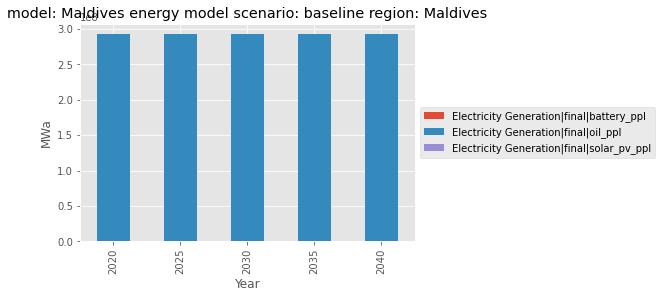

In [51]:
elec = elec_gen.filter(region=['Maldives'], variable='Electricity Generation|final|*', year=plotyrs)
elec.plot.bar(stacked=True)

In [52]:
rep.set_filters(c = 'cooling')
cool = rep.full_key('out')
cool = cool.drop('yv','m','nd','hd','h')
cool_gen = rep.get(cool)
cool_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=cool,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_cool = rep.get(new_key)
df_cool.data.unit = 'MWa'
df_cool.to_csv('cooling.csv')

In [53]:
elec_gen = pd.read_csv("cooling.csv")
elec_gen.columns 

Index(['Model', 'Scenario', 'Region', 'Variable', 'Unit', 'C', '2020', '2025',
       '2030', '2035', '2040'],
      dtype='object')

In [54]:
# Loading data from csv into a pyam format
cool_gen = pyam.IamDataFrame(data='cooling.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
cool_gen.data

INFO:pyam.core:Reading file cooling.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2020,cooling,283662.0
1,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2025,cooling,446148.0
2,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2030,cooling,490212.0
3,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2035,cooling,501228.0
4,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ac,MWta,2040,cooling,506736.0
5,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2020,cooling,0.0
6,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2025,cooling,0.0
7,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2030,cooling,0.0
8,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2035,cooling,0.0
9,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,MWta,2040,cooling,0.0


<AxesSubplot:title={'center':'model: Maldives energy model scenario: baseline region: Maldives'}, xlabel='Year', ylabel='MWta'>

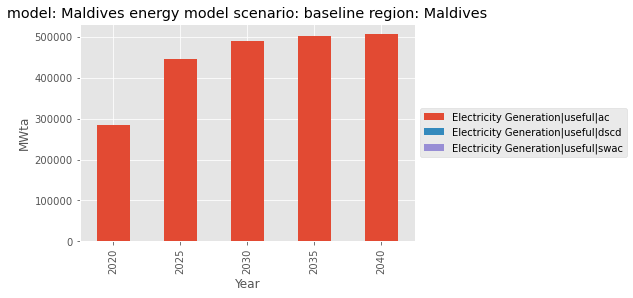

In [55]:
cool = cool_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
cool.plot.bar(stacked=True)

In [56]:
rep.set_filters(c = 'freshwater')
wat = rep.full_key('out')
wat = wat.drop('yv','m','nd','hd','h')
wat_gen = rep.get(wat)
wat_gen

def collapse_callback(df):
    """Callback function to populate the IAMC 'variable' column."""
    df['variable'] = 'Electricity Generation|' + df['l']+ '|'+df['t']
    return df.drop(['t','l'], axis =1)
    
new_key = rep.convert_pyam(
        quantities=wat,
        year_time_dim='ya',
        collapse=collapse_callback)
    
new_key = new_key[0]  # Unwrap the single item in the list
    
df_wat = rep.get(new_key)
df_wat.data.unit = 'm^3'
df_wat.to_csv('freshwater.csv')

In [57]:
elec_gen = pd.read_csv("freshwater.csv")

In [58]:
# Loading data from csv into a pyam format
wat_gen = pyam.IamDataFrame(data='freshwater.csv', encoding='ISO-8859-1')
# Looking into data in the pyam format
wat_gen.data

INFO:pyam.core:Reading file freshwater.csv


,model,scenario,region,variable,unit,year,c,value
0,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2020,freshwater,0.0
1,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2025,freshwater,0.0
2,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2030,freshwater,0.0
3,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2035,freshwater,0.0
4,Maldives energy model,baseline,Maldives,Electricity Generation|useful|dscd,a * m ** 3,2040,freshwater,0.0
5,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2020,freshwater,29200000.0
6,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2025,freshwater,29200000.0
7,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2030,freshwater,29200000.0
8,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2035,freshwater,29200000.0
9,Maldives energy model,baseline,Maldives,Electricity Generation|useful|ro_pl,a * m ** 3,2040,freshwater,29200000.0


<AxesSubplot:title={'center':'model: Maldives energy model scenario: baseline region: Maldives'}, xlabel='Year', ylabel='a * m ** 3'>

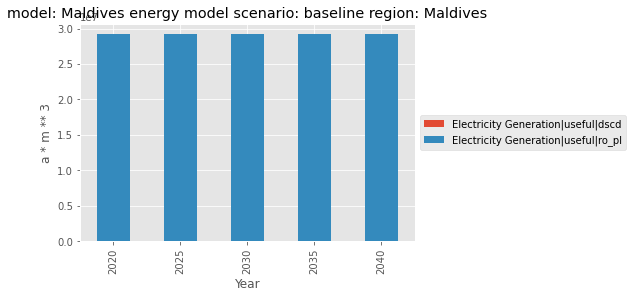

In [59]:
wat = wat_gen.filter(region=['Maldives'], variable='Electricity Generation|useful|*', year=plotyrs)
wat.plot.bar(stacked=True)

In [60]:
mp.close_db()